In [23]:
#r "nuget: GraphQL.Client"
#r "nuget: GraphQL.Client.Serializer.Newtonsoft"
#r "nuget: Plotly.NET.Interactive"
#r "nuget: Plotly.NET.ImageExport"

open GraphQL
open GraphQL.Client.Http
open GraphQL.Client.Serializer.Newtonsoft
open System
open Plotly.NET
open Plotly.NET.ImageExport

let baseUrl = "https://camaradosdeputadosgql-qboe6n5gda-uc.a.run.app/graphql"
//let baseUrl = "http://localhost:5078/graphql"
let graphQLClient = new GraphQLHttpClient(baseUrl, new NewtonsoftJsonSerializer());

let deputyRequest party state year month = new GraphQLRequest (
    $"""
    query {{
        deputies (party: "{party}" state: "{state}") {{
            name
            party
            picture
            expenses (year: "{year}" month: "{month}") {{
                netValue
                documentDate
            }}
        }}
    }}
    """
)

let expenseRequest name year = new GraphQLRequest (
    $"""
    query {{
        deputies (name: "{name}") {{
            name
            party
            state
            picture
            expenses (year: "{year}") {{
                netValue
                documentDate
                supplierCnpjOrCpf
                expenseType
                supplierName
            }}
        }}
    }}
    """
)

type DeputyResponse = {
    deputies: Deputy list
} 
and Deputy = {
    name: string
    party: string
    picture: string
    expenses: Expense[]
}
and Expense = {
    netValue: decimal
    expenseType: string
    supplierName: string
    documentDate: Nullable<DateTime>
}

let GetDeputies party state year month =
    let response =
        graphQLClient.SendQueryAsync<DeputyResponse>(deputyRequest party state year month)
        |> Async.AwaitTask
        |> Async.RunSynchronously
    response.Data.deputies

let GetExpenses deputy year = 
    let response = 
        graphQLClient.SendQueryAsync<DeputyResponse>(expenseRequest deputy year)
        |> Async.AwaitTask
        |> Async.RunSynchronously
    response.Data.deputies |> Seq.head

let stackedArea(deputy:Deputy) =
    deputy.expenses
    |> Seq.groupBy(fun it -> it.expenseType)
    |> Seq.map( fun (supplier, expenses) ->
        let dates, values =
            expenses
            |> Seq.filter(fun it -> it.documentDate.HasValue)
            |> Seq.sortBy(fun it -> it.documentDate.Value)
            |> Seq.map(fun it -> it.documentDate.Value, it.netValue)
            |> Seq.toArray
            |> Array.unzip
        Chart.Point(dates, values, Name = supplier)
        
    )
    |> Chart.combine

let scatter (deputy:Deputy) =
    let dates, values =
        if deputy.expenses <> null then
            deputy.expenses
            |> Array.filter(fun expense -> expense.documentDate.HasValue)
            |> Array.sortBy(fun expense -> expense.documentDate.Value)
            |> Array.map (fun expense -> expense.documentDate.Value, expense.netValue)
            |> Array.unzip
        else
            [||],[||]
    Chart.Line(dates, values)
    |> Chart.withLegendStyle(Orientation = StyleParam.Orientation.Horizontal)
    |> Chart.withTraceInfo deputy.name

let expenseChart (deputy:Deputy) =
    let labels, values =
        deputy.expenses
        |> Seq.groupBy(fun expense -> expense.expenseType)
        |> Seq.map (fun (name, expenses) ->
            let total =
                expenses
                |> Seq.sumBy ( fun expense -> expense.netValue )
            name, total
        )
        |> Seq.toList
        |> List.unzip
    Chart.Pie(Labels=labels, values=values)
    

Installed Packages GraphQL.Client, 5.1.0 GraphQL.Client.Serializer.Newtonsoft, 5.1.0 Plotly.NET.ImageExport, 3.0.1 Plotly.NET.Interactive, 3.0.2

In [89]:
let deputado:Deputy = GetExpenses "Luiza Erundina" 2021

In [90]:
deputado
|> stackedArea
|> Chart.withLegendStyle(Orientation = StyleParam.Orientation.Horizontal)
|>Chart.withLayoutStyle(Width = 1200, Height = 800)

<!-- Plotly chart will be drawn inside this DIV -->

In [91]:
let logYaxis =
    LinearAxis.init(
        Title = Title.init(Text = "Valor em R$"),
        AxisType = StyleParam.AxisType.Log
    )
let suppliers, values =    
    deputado.expenses
    |> Seq.groupBy(fun it -> it.supplierName)
    |> Seq.map(fun (supplier, expenses) -> supplier, (expenses |> Seq.sumBy( fun it -> it.netValue)))
    |> Seq.sortBy snd
    |> Seq.toArray |> Array.unzip
Chart.Bar(values, suppliers)
|>Chart.withLayoutStyle(Width = 1200, Height = 2000)
|>Chart.withXAxis logYaxis

<!-- Plotly chart will be drawn inside this DIV -->

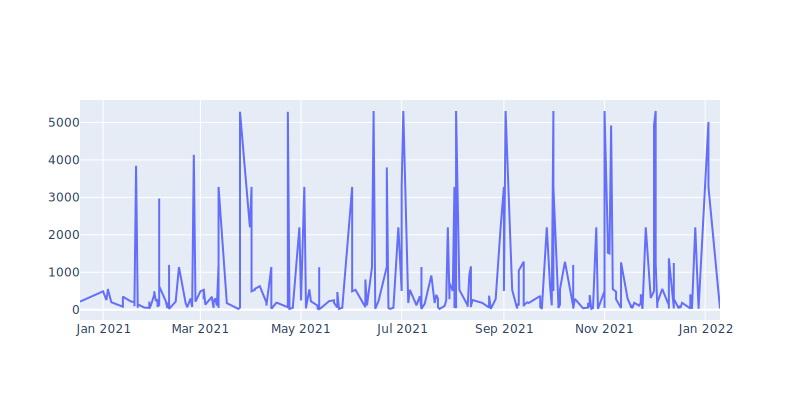

In [92]:
let graph =
    seq { yield deputado }
    |> Seq.map scatter
    |> Chart.combine
    |> Chart.toSVGString( Width = 800, Height = 400)

DisplayExtensions.DisplayAs(graph,"image/svg+xml")

In [93]:
HTML($"<img src=\"{deputado.picture}\"></img>")